# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第5节 选股策略的开发</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)


在第一节即说过:

- 在对的时间，遇见对的人(股票)，是一种幸福 
- 在对的时间，遇见错的人(股票)，是一种悲伤 
- 在错的时间，遇见对的人(股票)，是一声叹息 
- 在错的时间，遇见错的人(股票)，是一种无奈 

之前的节讲的都是择时(什么时候投资), 本节将讲解选股。

首先导入abupy中本节使用的模块：

In [1]:
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


### 1. 选股因子的编写

与择时小节类似，实现示例在中abu量化系统实现一个选股策略。

如下代码AbuPickRegressAngMinMax为选股因子，它的作用是将股票前期走势进行线性拟合计算一个角度，参数为选股条件，将选股条件作用于角度后进行股票的筛选。

In [3]:
from abupy import AbuPickStockBase, ps, ABuRegUtil

class AbuPickRegressAngMinMax(AbuPickStockBase):
    """拟合角度选股因子示例类"""
    def _init_self(self, **kwargs):
        """通过kwargs设置拟合角度边际条件，配置因子参数"""

        # 暂时与base保持一致不使用kwargs.pop('a', default)方式
        # fit_pick中 ang > threshold_ang_min, 默认负无穷，即默认所有都符合
        self.threshold_ang_min = -np.inf
        if 'threshold_ang_min' in kwargs:
            # 设置最小角度阀值
            self.threshold_ang_min = kwargs['threshold_ang_min']

        # fit_pick中 ang < threshold_ang_max, 默认正无穷，即默认所有都符合
        self.threshold_ang_max = np.inf
        if 'threshold_ang_max' in kwargs:
            # 设置最大角度阀值
            self.threshold_ang_max = kwargs['threshold_ang_max']

    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据自定义拟合角度边际参数进行选股"""
        # 计算走势角度
        ang = ABuRegUtil.calc_regress_deg(kl_pd.close, show=False)
        # 根据参数进行角度条件判断
        if self.threshold_ang_min < ang < self.threshold_ang_max:
            return True
        return False
    
    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickRegressAng fit_first_choice unsupported now!')

上面编写的AbuPickRegressAngMinMax即为一个完整的选股策略：

1. 选股策略必须继承自AbuPickStockBase
2. 选股策略必须实现fit_pick，即完成通过选股阶段金融时间序列对股票决策是否选中
3. 选股策略必须实现fit_first_choice, 但是可以raise NotImplementedError，fit_first_choice后面的章节示例
4. fit_pick上的装饰器ps.reversed_result稍后讲解

选股模块主要功能依托AbuPickStockWorker，其类似择时模块中的AbuPickTimeWorker，其通过init_stock_pickers()函数将所有选股因子实例化，然后在之后的fit()操作中，遍历所有选股因子，使用选股因子的fit_pick()函数，保留所有选股因子的fit_pick()都返回True的股票，只要有一个选股因子的fit_pick结果是False就将股票剔除。

详细代码请查阅 AbuPickStockWorker源代码。

本节只讲简单讲解选股使用示例，比如只想选取符合上升走势的股票：

In [4]:
from abupy import AbuPickStockWorker
from abupy import AbuBenchmark, AbuCapital, AbuKLManager

# 选股条件threshold_ang_min=0.0, 即要求股票走势为向上上升趋势
stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 0.0, 'reversed': False}]

# 从这几个股票里进行选股，只是为了演示方便
# 一般的选股都会是数量比较多的情况比如全市场股票
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']

benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
kl_pd_manger = AbuKLManager(benchmark, capital)
stock_pick = AbuPickStockWorker(capital, benchmark, kl_pd_manger,
                                choice_symbols=choice_symbols,
                                stock_pickers=stock_pickers)
stock_pick.fit()
# 打印最后的选股结果
stock_pick.choice_symbols

pid:19385 pick stocks complete:100.0%
pid:19385 done!


['usSFUN', 'usBIDU', 'usTSLA', 'usWUBA', 'usVIPS']

上面的实现方式和第一节中讲解择时回测的使用时一样通过分解流程方式一步一步实现使用AbuPickStockWorker进行选股，目的是为了更清晰的说明内部操作流程，编码过程会显的有些复杂臃肿。

实际上在编写完成一个策略后只需要abu.run_loop_back()函数即可以完成回测，在后面的小节中会进行讲解。

上面选股的结果将noah剔除，因为它在回测之前的选股周期内趋势为下降趋势，如下图所示：

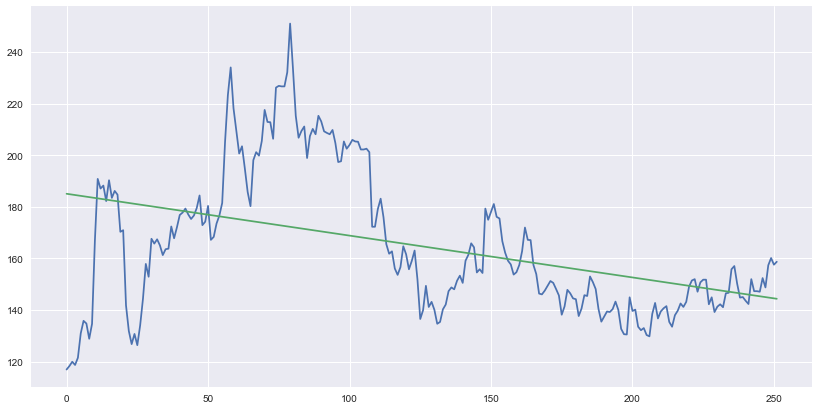

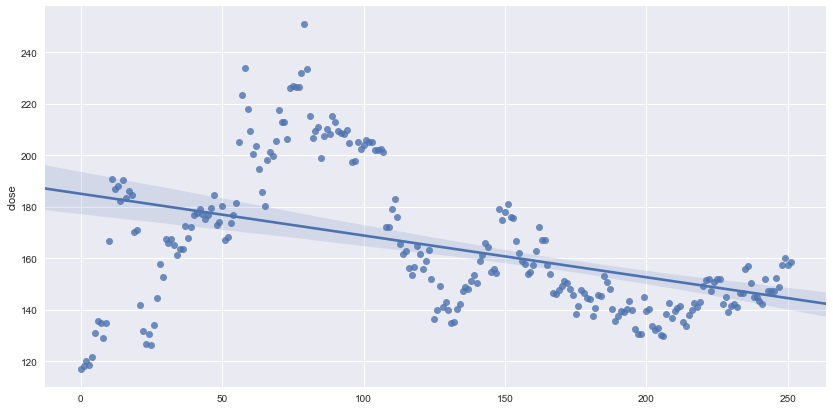

noah 选股周期内角度=-9.289


In [5]:
# 从kl_pd_manger缓存中获取选股走势数据，
# 注意get_pick_stock_kl_pd()为选股数据，get_pick_time_kl_pd()为择时
kl_pd_noah = kl_pd_manger.get_pick_stock_kl_pd('usNOAH')
# 绘制并计算角度
deg = ABuRegUtil.calc_regress_deg(kl_pd_noah.close)
print('noah 选股周期内角度={}'.format(round(deg, 3)))

注意上面的选股数据要使用择时回测数据之前的一段时间数据，在AbuPickStockBase中定义了xd，min_xd选股周期获取参数，
在AbuKLManager中通过get_pick_stock_kl_pd()函数配合xd，min_xd参数获取选股周期数据

更多详情请阅读AbuPickStockBase源代码与AbuKLManager源代码

上述选股代码实现在ABuPickStockExecute.do_pick_stock_work()中进行了封装，即讲AbuPickStockWorker及一些零散操作进行封装。

更多详情请阅读ABuPickStockExecute，使用示例如下所示：

eg：继续使用AbuPickRegressAngMinMax做为选股因子，如下定义threshold_ang_min＝0.0， threshold_ang_max＝10.0，即只选取上升趋势且上升角度小于10度的股票，下面示例使用ABuPickStockExecute.do_pick_stock_work()函数

In [6]:
from abupy import ABuPickStockExecute

stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 0.0, 'threshold_ang_max': 10.0,
                  'reversed': False}]

ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark,
                                       capital, stock_pickers)

pid:19385 pick stocks complete:100.0%
pid:19385 done!


['usSFUN', 'usBIDU']

可以看到结果sfun和baidu都符合，下面代码验证一下：

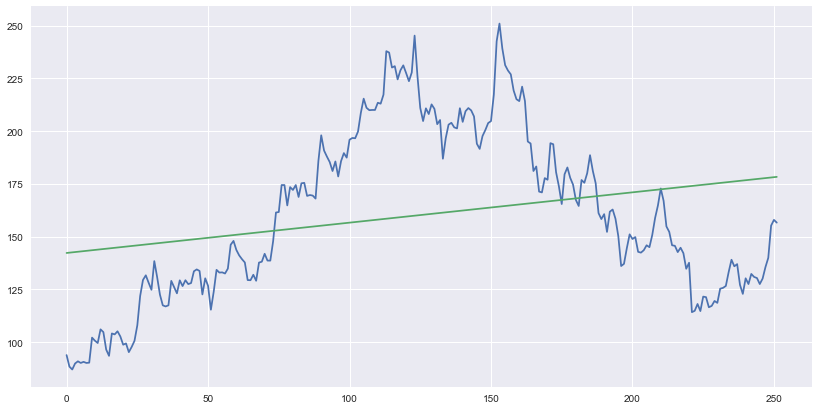

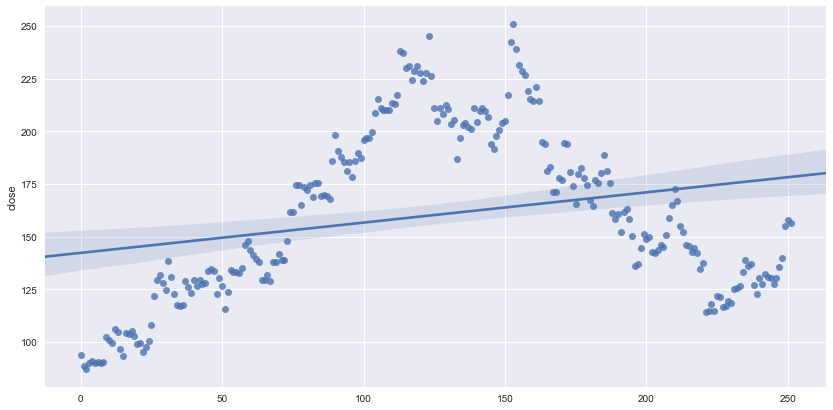

sfun 选股周期内角度=8.230


In [7]:
kl_pd_sfun = kl_pd_manger.get_pick_stock_kl_pd('usSFUN')
print('sfun 选股周期内角度={:.3f}'.format(ABuRegUtil.calc_regress_deg(kl_pd_sfun.close)))

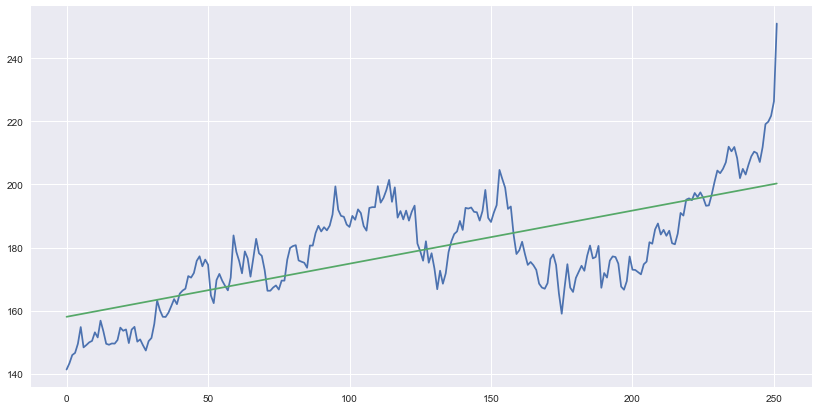

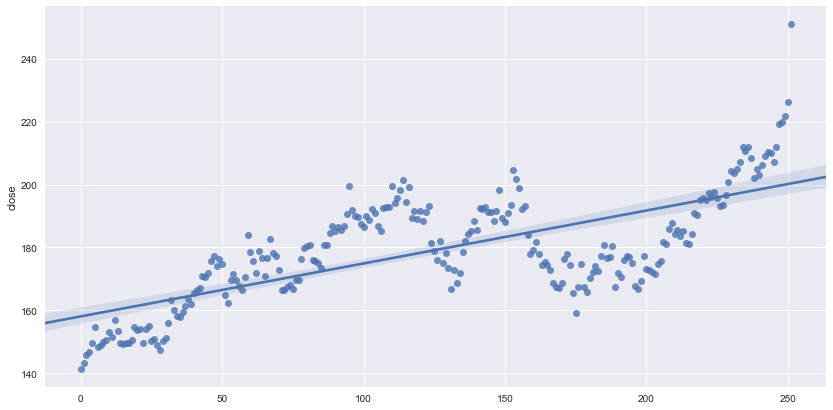

bidu 选股周期内角度=9.644


In [8]:
kl_pd_baidu = kl_pd_manger.get_pick_stock_kl_pd('usBIDU')
print('bidu 选股周期内角度={:.3f}'.format(ABuRegUtil.calc_regress_deg(kl_pd_baidu.close)))

上面结果显示两支股票在选股周期中的价格趋势拟合角度都在0-10之间。

假设修改需求想要选取周期内趋势角度在0度－10度之外的所有股票，可以这样编写代码：

In [9]:
# 和上面的代码唯一的区别就是reversed=True
stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 0.0, 'threshold_ang_max': 10.0,
                  'reversed': True}]

ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark,
                                       capital, stock_pickers)

pid:19385 pick stocks complete:100.0%
pid:19385 done!


['usNOAH', 'usTSLA', 'usWUBA', 'usVIPS']

可以看到结果与之前相反除了baidu和sfun之外所有股票都被选上，由于在AbuPickStockBase中定义函数reversed_result()，它的作用就是定义结果是否反转。

具体实现请阅读AbuPickStockBase中reversed_result装饰器的实现。

使用实际很简单，在每个具体的选股因子上的fit_pick()函数上根据需要选择是否安上装饰器，如下编写价格选股因子所示：

In [10]:
class AbuPickStockPriceMinMax(AbuPickStockBase):
    """价格选股因子示例类"""
    def _init_self(self, **kwargs):
        """通过kwargs设置选股价格边际条件，配置因子参数"""

        # 暂时与base保持一致不使用kwargs.pop('a', default)方式
        # fit_pick中选择 > 最小(threshold_price_min), 默认负无穷，即默认所有都符合
        self.threshold_price_min = -np.inf
        if 'threshold_price_min' in kwargs:
            # 最小价格阀值
            self.threshold_price_min = kwargs['threshold_price_min']

        # fit_pick中选择 < 最大(threshold_price_max), 默认正无穷，即默认所有都符合
        self.threshold_price_max = np.inf
        if 'threshold_price_max' in kwargs:
            # 最大价格阀值
            self.threshold_price_max = kwargs['threshold_price_max']

    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据自定义价格边际参数进行选股"""
        if kl_pd.close.max() < self.threshold_price_max and kl_pd.close.min() > self.threshold_price_min:
            # kl_pd.close的最大价格 < 最大价格阀值 且 kl_pd.close的最小价格 > 最小价格阀值
            return True
        return False

    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickStockPriceMinMax fit_first_choice unsupported now!')

备注：本节所编写的选股示例代码以内置在abupy项目代码中可通过如下方式直接导入：

    from abupy import AbuPickStockPriceMinMax
    from abupy import AbuPickRegressAngMinMax

### 2. 多个选股因子并行执行

1. ABuPickRegressAngMinMax: threshold_ang_min=0.0, 即要求股票走势为向上，上升趋势
2. ABuPickStockPriceMinMax threshold_price_min=50.0, 即要求股票在选股周期内股价最小值要大于50.0

继续使用ABuPickStockExecute，使上面两个选股因子同时生效，结果符合的只有BIDU及TSLA，代码如下所示：

In [11]:
from abupy import AbuPickStockPriceMinMax


# 选股list使用两个不同的选股因子组合，并行同时生效
stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 0.0, 'reversed': False},
                 {'class': AbuPickStockPriceMinMax,
                  'threshold_price_min': 50.0,
                  'reversed': False}]

%time ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark, capital, stock_pickers)

pid:19385 pick stocks complete:100.0%
pid:19385 done!
CPU times: user 519 ms, sys: 49.6 ms, total: 569 ms
Wall time: 793 ms


['usBIDU', 'usTSLA']

### 3. 使用并行来提升选股运行效率

与并行择时实现方式类似，选股使用AbuPickStockMaster并行执行多个进程来提升选股效率。

具体代码请查询AbuPickStockMaster，下面为使用示例, 使用do_pick_stock_with_process()函数执行默认n_process_pick_stock=8，即默认同时运行8个进程。

备注：下面都通过import的方式导入了模块，因为在windows系统上，启动并行后，在ipython notebook中定义的类会在子进程中无法找到

In [20]:
%%time
from abupy import AbuPickStockMaster
from abupy import AbuPickRegressAngMinMax, AbuPickStockPriceMinMax

# 选股list使用两个不同的选股因子组合，并行同时生效
stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 0.0, 'reversed': False},
                 {'class': AbuPickStockPriceMinMax,
                  'threshold_price_min': 50.0,
                  'reversed': False}]

cs = AbuPickStockMaster.do_pick_stock_with_process(capital, benchmark, stock_pickers, choice_symbols)

pid:6614 pick stocks complete:100.0%
pid:6615 pick stocks complete:100.0%
pid:6616 pick stocks complete:100.0%
pid:6617 pick stocks complete:100.0%
pid:6618 pick stocks complete:100.0%
pid:6619 pick stocks complete:100.0%
pid:6620 pick stocks complete:100.0%
pid:6621 pick stocks complete:100.0%
pid:6617 done!
pid:6618 done!
pid:6615 done!
pid:6614 done!
pid:6616 done!
pid:6620 done!
pid:6619 done!
pid:6621 done!
CPU times: user 89.9 ms, sys: 43.7 ms, total: 134 ms
Wall time: 419 ms


从上面输出可以看到选股阶段启动了8个进程，因为股票数量太少，进程启动销毁也需要一定时间，所以上例整体效率并没有提高。

更多示例请阅读《量化交易之路》书中的示例以及对应的ipython代码或者python代码

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)